# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [30]:
# Set the theme here
THEME = 'eu_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [31]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [32]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [33]:
df = pd.read_csv(f'../data/{THEME}.csv')
import numpy as np


In [34]:
# Parameters
# PARAMETERS FOR EU: MIN_CLUSTER_SIZE = 50, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.1
# PARAMETERS FOR WAR: MIN_CLUSTER_SIZE = 20, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.05
# PARAMETERS FOR HEALTHCARE: MIN_CLUSTER_SIZE = 20, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.05
HDBSCAN_MIN_CLUSTER_SIZE = int(np.sqrt(len(df)))
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [35]:
df['Speaker_party'].describe()

count               6594
unique                19
top       Fidesz-frakció
freq                2667
Name: Speaker_party, dtype: object

In [36]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [37]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)


In [38]:
pd.Series(new_topics).value_counts()

 0    4070
 1     647
 2     474
 3     386
 4     344
-1     297
 5     203
 6     134
 7     101
dtype: int64

In [39]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [40]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [41]:
# Number of topics
print(f"Number of topics: {len(pd.Series(new_topics).unique())}")

Number of topics: 9


In [42]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

 4    3816
-1     823
 6     533
 0     446
 3     340
 1     323
 2     183
 5      98
 7      94
dtype: int64

In [43]:
topic_model.visualize_topics()

What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [44]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

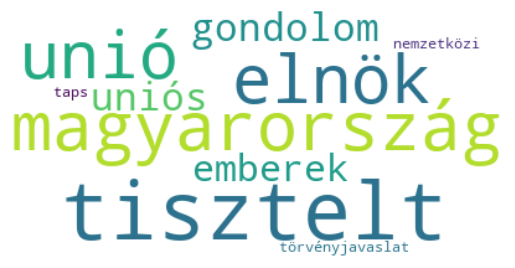

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [46]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [47]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [48]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
speech_topic_party.loc[speech_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
speech_topic_party.loc[speech_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,2216,1271,538
1,367,198,78
2,261,165,46
3,162,146,73
4,218,87,37
5,128,67,8
6,70,48,15
7,40,45,15


In [49]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,64.0,62.7,66.4
1,10.6,9.8,9.6
2,7.5,8.1,5.7
3,4.7,7.2,9.0
4,6.3,4.3,4.6
5,3.7,3.3,1.0
6,2.0,2.4,1.9
7,1.2,2.2,1.9


In [50]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
# percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-KDNP,OTHER,Opposition,keywords
topic,,,,
0,64.0,62.7,66.4,"[tisztelt, magyarország, elnök, unió, gondolom..."
1,10.6,9.8,9.6,"[költségvetés, tisztelt, uniós, magyarország, ..."
2,7.5,8.1,5.7,"[szén, klímaváltozás, európai, 2030, villamos,..."
3,4.7,7.2,9.0,"[milliárd, 2010, magyar, költségvetésben, gond..."
4,6.3,4.3,4.6,"[magyar, vakcina, európai, elnök, védekezés, k..."
5,3.7,3.3,1.0,"[gmo, biológiai, mezőgazdaság, élelmiszerek, m..."
6,2.0,2.4,1.9,"[szabadkereskedelmi, ceta, ttip, kanada, európ..."
7,1.2,2.2,1.9,"[uniós, fejlesztési, pénzeket, támogatások, ko..."


In [51]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
# percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-KDNP,OTHER,Opposition
0,0,55.1,31.6,13.4
1,1,57.1,30.8,12.1
2,2,55.3,35.0,9.7
3,3,42.5,38.3,19.2
4,4,63.7,25.4,10.8
5,5,63.1,33.0,3.9
6,6,52.6,36.1,11.3
7,7,40.0,45.0,15.0


Calculate mean sentiment for each topic per party

In [52]:
# sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
# sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,-0.13,-0.40,-0.32
1,0.03,-0.48,-0.50
2,0.05,-0.48,-0.40
3,-0.19,-0.48,-0.44
4,-0.28,-0.39,-0.53
5,0.02,-0.48,-0.50
6,0.30,-0.17,0.09
7,-0.27,-0.41,-0.59


In [53]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [54]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['Fidesz-KDNP', 'Opposition', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'Fidesz-KDNP')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,sentiment,speech_date,prob,speech
63,0,u2017-03-21-27,Fidesz-KDNP,0.989746,2017-03-21,0.329893,Köszönöm a szót. Tisztelt Országgyűlés! A honv...
5793,0,u2018-10-08-111,Fidesz-KDNP,0.987305,2018-10-08,0.996696,Tisztelt Frakcióvezető Úr! Indulatos szavai te...
5600,0,u2018-05-10-3,Fidesz-KDNP,0.923340,2018-05-10,0.435548,Tisztelt Köztársasági Elnök Úr! Tisztelt Házel...
1410,0,u2021-06-07-17,Fidesz-KDNP,-1.000000,2021-06-07,0.509503,"Köszönöm szépen a szót, elnök úr. Tisztelt Kép..."
5390,0,u2018-06-26-15,Fidesz-KDNP,-1.000000,2018-06-26,0.430240,"Ezek szerint ön is tudja, hogy mire gondolunk,..."
...,...,...,...,...,...,...,...
2276,7,u2015-05-28-207,OTHER,0.464111,2015-05-28,0.063092,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt..."
5190,7,u2018-06-28-55,OTHER,0.329102,2018-06-28,0.998324,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt..."
1818,7,u2015-03-31-232,OTHER,-0.957520,2015-03-31,0.995482,Tisztelt Elnök Úr! Tisztelt Ház! A tárgyszerűs...
4516,7,u2016-04-25-73,OTHER,-0.982422,2016-04-25,0.997032,"Nem fogadom el a választ. Államtitkár úr, tény..."


In [55]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.Fidesz-KDNP', 'pf.OTHER', 'pf.Opposition', 'keywords', 'tc.Fidesz-KDNP', 'tc.OTHER', 'tc.Opposition', 's.Fidesz-KDNP', 's.OTHER', 's.Opposition']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.Fidesz-KDNP', 'tc.Opposition', 'tc.OTHER', 'pf.Fidesz-KDNP', 'pf.Opposition', 'pf.OTHER', 's.Fidesz-KDNP', 's.Opposition', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.Fidesz-KDNP,tc.Opposition,tc.OTHER,pf.Fidesz-KDNP,pf.Opposition,pf.OTHER,s.Fidesz-KDNP,s.Opposition,s.OTHER
topic,,,,,,,,,,
0,"[tisztelt, magyarország, elnök, unió, gondolom...",55.1,13.4,31.6,64.0,66.4,62.7,-0.13,-0.32,-0.40
1,"[költségvetés, tisztelt, uniós, magyarország, ...",57.1,12.1,30.8,10.6,9.6,9.8,0.03,-0.50,-0.48
2,"[szén, klímaváltozás, európai, 2030, villamos,...",55.3,9.7,35.0,7.5,5.7,8.1,0.05,-0.40,-0.48
3,"[milliárd, 2010, magyar, költségvetésben, gond...",42.5,19.2,38.3,4.7,9.0,7.2,-0.19,-0.44,-0.48
4,"[magyar, vakcina, európai, elnök, védekezés, k...",63.7,10.8,25.4,6.3,4.6,4.3,-0.28,-0.53,-0.39
5,"[gmo, biológiai, mezőgazdaság, élelmiszerek, m...",63.1,3.9,33.0,3.7,1.0,3.3,0.02,-0.50,-0.48
6,"[szabadkereskedelmi, ceta, ttip, kanada, európ...",52.6,11.3,36.1,2.0,1.9,2.4,0.30,0.09,-0.17
7,"[uniós, fejlesztési, pénzeket, támogatások, ko...",40.0,15.0,45.0,1.2,1.9,2.2,-0.27,-0.59,-0.41
